In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p

In [3]:
train_test_str = 'train_test'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125 250
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str, parc_str = parc_str, parc_scale = parc_scale)

In [4]:
# output file prefix
outfile_prefix = exclude_str+'_'+parc_str+'_'+str(parc_scale)+'_'
outfile_prefix

't1Exclude_schaefer_400_'

### Setup directory variables

In [5]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/3_output_nosibs/figs


## Load data pre-nispat data

In [6]:
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', outfile_prefix+'df.csv'))

In [7]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True)
df_node_train = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True)

# Test
df_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'test.csv'))
df_test.set_index(['bblid', 'scanid'], inplace = True)
df_node_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_test.csv'))
df_node_test.set_index(['bblid', 'scanid'], inplace = True)

# concat
df = pd.concat((df_train, df_test), axis = 0); print(df.shape)
df_node = pd.concat((df_node_train, df_node_test), axis = 0); print(df_node.shape)

(1271, 57)
(1271, 800)


In [8]:
smse = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out', 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)

expv = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out', 'expv.txt'), delimiter = ' ').transpose()
df_expv = pd.DataFrame(data = expv, index = df_node.columns)

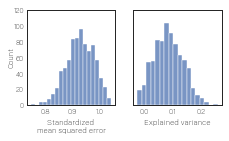

In [9]:
sns.set(style='white', context = 'paper', font_scale = 0.8)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Public Sans']})

f, ax = plt.subplots(1,2)
f.set_figwidth(3.5)
f.set_figheight(1.75)

sns.histplot(smse, ax=ax[0])
ax[0].set_xlabel('Standardized \nmean squared error')
ax[0].tick_params(pad = -2)
ax[0].set_ylabel('Count', labelpad=-1)
ax[0].set_ylim([0,120])

sns.histplot(expv, ax=ax[1])
ax[1].set_xlabel('Explained variance')
ax[1].tick_params(pad = -2)
ax[1].set_ylabel('')
ax[1].set_ylim([0,120])
ax[1].set_yticklabels('')

f.savefig(outfile_prefix+'nm_diagnostics.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Load nispat outputs

In [10]:
# Forward model
synth_cov_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'cov_test_forward.txt'),
                             delim_whitespace = True, names=['ageAtScan1_Years', 'sex_adj'])

yhat_forward = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out_forward', 'yhat.txt'), delimiter = ' ').transpose()
df_yhat_forward = pd.DataFrame(data = yhat_forward, index = synth_cov_test.index, columns = df_node.columns)

ys2_forward = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out_forward', 'ys2.txt'), delimiter = ' ').transpose()
df_ys2_forward = pd.DataFrame(data = ys2_forward, index = synth_cov_test.index, columns = df_node.columns)

In [11]:
df_yhat_forward_tmp = df_yhat_forward + (df_yhat_forward.abs().max()+1)
print((df_yhat_forward_tmp<0).any().any())

annualized = True
if annualized:
    elapsed_time = synth_cov_test.loc[synth_cov_test['sex_adj'] == 0,'ageAtScan1_Years'].iloc[-1] - synth_cov_test.loc[synth_cov_test['sex_adj'] == 0,'ageAtScan1_Years'].iloc[0]
    print(elapsed_time)
    x = (df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[0,:]) - 1
    df_yhat_tmp1 = (np.power(1+x.abs(),1/elapsed_time)-1)*100
    df_yhat_tmp1[x<0] = df_yhat_tmp1[x<0]*-1

    x = (df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[0,:]) - 1
    df_yhat_tmp2 = (np.power(1+x.abs(),1/elapsed_time)-1)*100
    df_yhat_tmp2[x<0] = df_yhat_tmp2[x<0]*-1
else:
    df_yhat_tmp1 = ((df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[0,:]) - 1) * 100
    df_yhat_tmp2 = ((df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[0,:]) - 1) * 100

df_yhat_diff = pd.concat((df_yhat_tmp1, df_yhat_tmp2), axis = 1)
df_yhat_diff.head()

False
15.000000000000002


,0,1
ct_0,-0.241677,-0.243400
ct_1,-0.332627,-0.336701
ct_2,-0.231961,-0.232917
ct_3,-0.582120,-0.587253
ct_4,0.110161,0.081579


In [12]:
df_yhat_diff.filter(regex = 'ct', axis = 0).abs().max()

0    0.951261
1    0.903523
dtype: float64

In [13]:
df_yhat_diff.filter(regex = 'vol', axis = 0).abs().max()

0    0.836055
1    0.975688
dtype: float64

## Setup plots

In [14]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

# metrics = ['ct', 'vol']
# metrics_label_short = ['Thickness', 'Volume']
# metrics_label = ['Thickness', 'Volume']
metrics = ['vol',]
metrics_label_short = ['Volume',]
metrics_label = ['Volume',]
print(metrics)

['vol']


## Brain plots nispat

In [15]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

Notebook initialized with png backend.


In [16]:
if parc_str == 'schaefer':
    subject_id = 'fsaverage'
elif parc_str == 'lausanne':
    subject_id = 'lausanne125'

0 = Male, 1 = Female

In [17]:
figs_to_delete = []

for metric in metrics:
    for hemi in ('lh', 'rh'):
        for sx in ('sex0','sex1'):
            # Plots of age correlation
            fig_str = hemi + '_' + metric + '_age_' + sx + '_frwd'
            figs_to_delete.append('ventral_'+fig_str)
            figs_to_delete.append('med_'+fig_str)
            figs_to_delete.append('lat_'+fig_str)
            
            if sx == 'sex0':
                roi_data = df_yhat_diff.loc[:,0].filter(regex = metric, axis = 0).values
            elif sx == 'sex1':
                roi_data = df_yhat_diff.loc[:,1].filter(regex = metric, axis = 0).values
            
            center_anchor = 1

            if subject_id == 'lausanne125':
                parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
            elif subject_id == 'fsaverage':
                parc_file = os.path.join('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                         hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

            brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, color = 'coolwarm', center_anchor = center_anchor)

1
1
1
1


# Figures

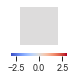

In [18]:
f, ax = plt.subplots(1)
f.set_figwidth(1)
f.set_figheight(1)

limit = 3
sns.heatmap(np.zeros((1,1)), annot = False, xticklabels = [""], yticklabels = [""], center = 0, vmax = limit, vmin = -limit, ax = ax, square = True, cmap = 'coolwarm', cbar_kws={"orientation": "horizontal"})
f.savefig('colorbar_'+str(limit)+'.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

Figure 2C

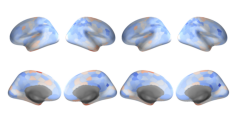

In [19]:
# Age effects
f, axes = plt.subplots(2, 4)
f.set_figwidth(4)
f.set_figheight(2)
plt.subplots_adjust(wspace=0, hspace=0)


# column 0:
fig_str = 'lh_vol_age_sex0_frwd.png'
try:
    image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
except FileNotFoundError: axes[0,0].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
except FileNotFoundError: axes[1,0].axis('off')

# column 1:
fig_str = 'rh_vol_age_sex0_frwd.png'
try:
    image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
except FileNotFoundError: axes[0,1].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
except FileNotFoundError: axes[1,1].axis('off')

# column 2:
fig_str = 'lh_vol_age_sex1_frwd.png'
try:
    image = mpimg.imread('lat_' + fig_str); axes[0,2].imshow(image); axes[0,2].axis('off')
except FileNotFoundError: axes[0,2].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,2].imshow(image); axes[1,2].axis('off')
except FileNotFoundError: axes[1,2].axis('off')

# column 3:
fig_str = 'rh_vol_age_sex1_frwd.png'
try:
    image = mpimg.imread('lat_' + fig_str); axes[0,3].imshow(image); axes[0,3].axis('off')
except FileNotFoundError: axes[0,3].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,3].imshow(image); axes[1,3].axis('off')
except FileNotFoundError: axes[1,3].axis('off')

plt.show()
f.savefig(outfile_prefix+'brain_age.svg', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

In [20]:
# for my_str in ('_sex0_frwd', '_sex1_frwd'):
#     # Age effects
#     f, axes = plt.subplots(2, 4)
#     f.set_figwidth(4)
#     f.set_figheight(2)
#     plt.subplots_adjust(wspace=0, hspace=0)


#     # column 0:
#     fig_str = 'lh_ct_age'+my_str+'.png'
#     try:
#         image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
#     except FileNotFoundError: axes[0,0].axis('off')
#     try:
#         image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
#     except FileNotFoundError: axes[1,0].axis('off')

#     # column 1:
#     fig_str = 'rh_ct_age'+my_str+'.png'
#     try:
#         image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
#     except FileNotFoundError: axes[0,1].axis('off')
#     try:
#         image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
#     except FileNotFoundError: axes[1,1].axis('off')

#     # column 2:
#     fig_str = 'lh_vol_age'+my_str+'.png'
#     try:
#         image = mpimg.imread('lat_' + fig_str); axes[0,2].imshow(image); axes[0,2].axis('off')
#     except FileNotFoundError: axes[0,2].axis('off')
#     try:
#         image = mpimg.imread('med_' + fig_str); axes[1,2].imshow(image); axes[1,2].axis('off')
#     except FileNotFoundError: axes[1,2].axis('off')

#     # column 3:
#     fig_str = 'rh_vol_age'+my_str+'.png'
#     try:
#         image = mpimg.imread('lat_' + fig_str); axes[0,3].imshow(image); axes[0,3].axis('off')
#     except FileNotFoundError: axes[0,3].axis('off')
#     try:
#         image = mpimg.imread('med_' + fig_str); axes[1,3].imshow(image); axes[1,3].axis('off')
#     except FileNotFoundError: axes[1,3].axis('off')

#     plt.show()
#     f.savefig(outfile_prefix+'brain_age'+my_str+'.svg', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)
# #     f.savefig('brain_age'+my_str+'.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [21]:
for file in figs_to_delete:
    try:
        os.remove(os.path.join(figdir,file+'.png'))
    except:
        print(file, 'not found')